In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'comp451/Project/visual-transformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

ROOT_PATH = PATH = '/content/drive/MyDrive/comp451/Project/visual-transformer'

os.chdir(ROOT_PATH)


Mounted at /content/drive


In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torchsummary import summary
from models.vt_resnet20 import VTResNet20
from models.resnet import BasicBlock
import matplotlib.pyplot as plt
import random
import pickle
import PIL
import numpy as np

In [28]:
def store_params(content, name):
    f = open("logs/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("logs/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded


In [29]:
def random_seed():
    np.random.seed(8)
    torch.manual_seed(8)
    random.seed(8)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
def get_data(name):

    transform_train = torchvision.transforms.Compose(
     [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
       # torchvision.transforms.RandomAffine(8, translate=(.15,.15)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

    transform_valid = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if name == 'CIFAR10':
        data_train = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid
    
    if name == 'MNIST':
        data_train = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid

    if name == 'ImageNet':
        data_train = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/Project/visual-transformer/data', split='train', transform=transform_train)
        data_valid = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/Project/visual-transformer/data', split='val', transform=transform_valid)

        return data_train, data_valid

In [32]:
data_train, data_valid = get_data('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(54,36;334.8x217.44)


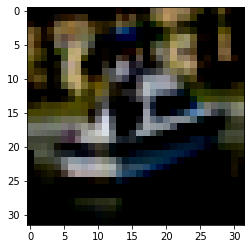

In [33]:
print(plt.imshow(data_train[501][0].permute(1,2,0)) )

In [34]:
def train(model, optimizer, data_loader):
   
    total_samples = len(data_loader.dataset)
    
    model.train()
    model.to(device)

    loss_history = []
    for i, (data, target) in enumerate(data_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
    return loss_history

In [35]:
def evaluate(model, data_loader, mode):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage '+ mode + ' loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy, loss_history

In [36]:
def train_attempt(model, optimizer, train_data, valid_data, epochs, lr, 
                  lr_decay, decay_every, weight_decay, optim):

    all_history = []
    final_train_acc = 0
    final_valid_acc = 0
    for i in range(epochs):

        if i % decay_every == 0:
            lr *= lr_decay
            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

        history = train(model, optimizer, train_data)
        all_history = all_history + history
        plt.plot(history)
        plt.show()
        print("Epoch " + str(i) + " done.")
        final_valid_acc, valid_hist = evaluate(model, valid_data, 'test')
        final_train_acc, train_hist = evaluate(model, train_data, 'train')
        
    plt.plot(all_history)
    plt.show()

    return final_valid_acc, final_train_acc, all_history

In [37]:
# L = 8
# D = 512
# layer_plane = [64, 128, 256, 512]
# enc_layer = 2
# n_heads = 8
# vt_channels = 64
# fc_dim = 1024
# dropout = 0.5
# vt_num_layers = 2
# input_dim = 32

# model = VTResNet20(
#     vt_num_layers=vt_num_layers,
#     tokens=L,
#     token_channels=D,
#     input_dim=input_dim,
#     vt_channels=vt_channels,
#     transformer_enc_layers=enc_layer,
#     transformer_heads=n_heads,
#     transformer_fc_dim=fc_dim,
#     transformer_dropout=dropout,
#     image_channels=3,
#     num_classes=10,
#     resnet_pretrained=True,
#     freeze_resnet=True
# )
 
# model.load_state_dict(torch.load(ROOT_PATH + '/saved_models/model4.pt')) # , map_location=torch.device('cpu')

In [38]:
# lr = 0.0001
# N = 128
# train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
# valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=N, shuffle=False)
# epochs = 10
# lr_decay = 1
# decay_every = 50
# weight_decay = 4e-5
# optim = torch.optim.Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# final_valid_acc, final_train_acc, all_history = train_attempt(
#     model, 
#     optimizer=optimizer, 
#     train_data=train_loader, 
#     valid_data=valid_loader, 
#     epochs=epochs, 
#     lr=lr, 
#     lr_decay=lr_decay, 
#     decay_every=decay_every,  
#     weight_decay=weight_decay, 
#     optim=optim
# )

In [39]:
valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=128, shuffle=False)
test_loader = DataLoader(Subset(data_valid, list(range(5000, 10000))), batch_size=128, shuffle=False)

def param_search():

    l = 0.005
    r = 0.004
    lr_trials = 1
    lrs = [0.0005, 0.0001, 0.001]
    Ls = [8, 16]
    Ns = [128]
    Ds = [512, 1024]
    optims = [torch.optim.Adam]
    weight_decay = 4e-5
    lr_decay = 0.5
    decay_every = 15
    epochs = 10
    enc_layers = [2]
    n_heads = [8]
    fc_dims = [512]
    t_dropout = [0.5]
    vt_channels_lst = [64] # [16, 32, 64, 128] 
    vt_num_layers = 2
    input_dim = 32
    

    best_model = None
    best = {}
    best['valid_acc'] = 0

    all_count = 0
    best_count = 0


    for N in Ns:
        train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
        for D in Ds:
            for lr in lrs:
                for vt_channels in vt_channels_lst:
                    for n_head in n_heads:
                        for fc_dim in fc_dims:
                            for dropout in t_dropout:
                                for enc_layer in enc_layers: 
                                    for optim in optims:
                                        #for _ in range(lr_trials):
                                           for L in Ls:
                                            # lr = random.uniform(l, r)
                                            # lr = 0.00425809562274105

                                            
                                            model = VTResNet20(
                                                vt_num_layers=vt_num_layers,
                                                    tokens=L,
                                                    token_channels=D,
                                                    input_dim=input_dim,
                                                    vt_channels=vt_channels,
                                                    transformer_enc_layers=enc_layer,
                                                    transformer_heads=n_head,
                                                    transformer_fc_dim=fc_dim,
                                                    transformer_dropout=dropout,
                                                    image_channels=3,
                                                    num_classes=10,
                                                    resnet_pretrained=True,
                                                    freeze_resnet=True
                                                )
                                            model.to(device)
                                            summary(model, (3, 32, 32))
                                        
                                            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

                                            valid_acc, train_acc, all_hist = train_attempt(
                                                model, 
                                                optimizer, 
                                                train_loader, 
                                                valid_loader, 
                                                epochs,
                                                lr,
                                                lr_decay,
                                                decay_every,
                                                weight_decay,
                                                optim
                                                )

                                            if valid_acc > best['valid_acc']:
                                                best_model = model
                                                best['valid_acc'] = valid_acc
                                                best['train_acc'] = train_acc
                                                best['lr'] = lr
                                                best['L'] = L
                                                best['N'] = N
                                                best['D'] = D
                                                best['optim'] = optim
                                                best['enc_layer'] = enc_layer
                                                best['fc_dim'] = fc_dim
                                                best['vt_num_layers'] = vt_num_layers
                                                best['vt_channels'] = vt_channels
                                                best['dropout'] = dropout
                                                best['n_head'] = n_head

                                                store_params(best, "best_params_1_" + str(best_count))
                                                best_count += 1

                                            params = {
                                                'valid_acc': valid_acc,
                                                'train_acc': train_acc,
                                                'lr': lr,
                                                'L': L,
                                                'N': N,
                                                'D': D,
                                                'optim': optim,
                                                'enc_layer': enc_layer,
                                                'fc_dim': fc_dim,
                                                'vt_num_layers': vt_num_layers,
                                                'vt_channels': vt_channels,
                                                'dropout': dropout,
                                                'n_head': n_head
                                            }
                                            store_params(params, "params_1_" + str(all_count))
                                            all_count += 1

                                            print("This Epoch Params:")
                                            print(params)
                                            print("\n")

                                            print('Best So Far:')
                                            print(best)

            

    return best, best_model

In [40]:
#torch.save(best_model.state_dict(), ROOT_PATH + '/saved_models/model3.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

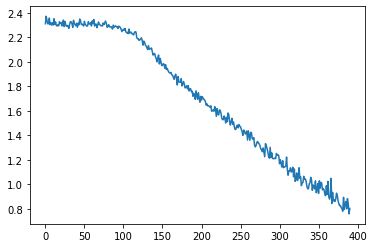

Epoch 0 done.

Average test loss: 0.7837  Accuracy: 4405/ 5000 (88.10%)


Average train loss: 0.7913  Accuracy:46328/50000 (92.66%)

[    0/50000 (  0%)]  Loss: 0.8204
[12800/50000 ( 26%)]  Loss: 0.4589
[25600/50000 ( 51%)]  Loss: 0.2924
[38400/50000 ( 77%)]  Loss: 0.2922


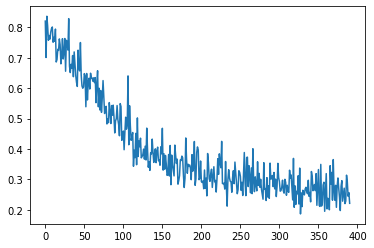

Epoch 1 done.

Average test loss: 0.3436  Accuracy: 4493/ 5000 (89.86%)


Average train loss: 0.2428  Accuracy:47055/50000 (94.11%)

[    0/50000 (  0%)]  Loss: 0.3210
[12800/50000 ( 26%)]  Loss: 0.2716
[25600/50000 ( 51%)]  Loss: 0.1586
[38400/50000 ( 77%)]  Loss: 0.1642


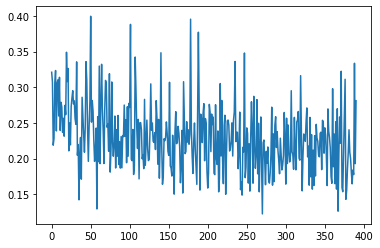

Epoch 2 done.

Average test loss: 0.3181  Accuracy: 4501/ 5000 (90.02%)


Average train loss: 0.1831  Accuracy:47207/50000 (94.41%)

[    0/50000 (  0%)]  Loss: 0.1682
[12800/50000 ( 26%)]  Loss: 0.2595
[25600/50000 ( 51%)]  Loss: 0.1908
[38400/50000 ( 77%)]  Loss: 0.2448


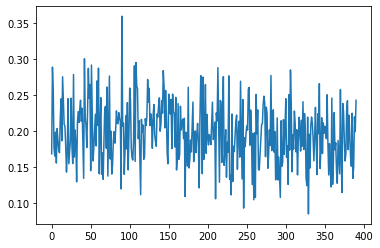

Epoch 3 done.

Average test loss: 0.3031  Accuracy: 4525/ 5000 (90.50%)


Average train loss: 0.1653  Accuracy:47394/50000 (94.79%)

[    0/50000 (  0%)]  Loss: 0.1610
[12800/50000 ( 26%)]  Loss: 0.1732
[25600/50000 ( 51%)]  Loss: 0.1896
[38400/50000 ( 77%)]  Loss: 0.1821


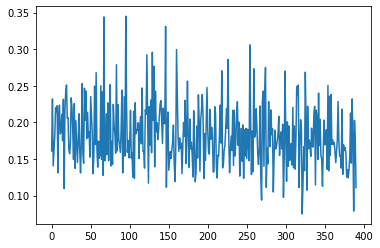

Epoch 4 done.

Average test loss: 0.3084  Accuracy: 4514/ 5000 (90.28%)


Average train loss: 0.1616  Accuracy:47422/50000 (94.84%)

[    0/50000 (  0%)]  Loss: 0.1671
[12800/50000 ( 26%)]  Loss: 0.1819
[25600/50000 ( 51%)]  Loss: 0.1704
[38400/50000 ( 77%)]  Loss: 0.1968


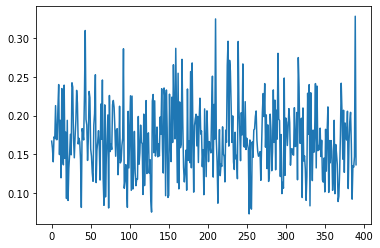

Epoch 5 done.

Average test loss: 0.3080  Accuracy: 4531/ 5000 (90.62%)


Average train loss: 0.1547  Accuracy:47444/50000 (94.89%)

[    0/50000 (  0%)]  Loss: 0.0991
[12800/50000 ( 26%)]  Loss: 0.2147
[25600/50000 ( 51%)]  Loss: 0.1437
[38400/50000 ( 77%)]  Loss: 0.1326


In [ ]:
random_seed()
best, best_model = param_search()

print(best)
store_params(best, "best_of_all_test")

acc, hist = evaluate(best_model, test_loader, 'testing')
print("Test Set Accuracy: ", acc)

In [20]:
torch.save(best_model.state_dict(), ROOT_PATH + '/saved_models/vt_resnet20_full_freeze_89.pt')

In [ ]:
"""
{'valid_acc': tensor(54.8400, device='cuda:0'), 'train_acc': tensor(50.4880, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73., device='cuda:0'), 'train_acc': tensor(70.2780, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73.3200, device='cuda:0'), 'train_acc': tensor(71.4700, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}

{'valid_acc': tensor(78.9200, device='cuda:0'), 'train_acc': tensor(91.1760, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 1024, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(76.2800, device='cuda:0'), 'train_acc': tensor(74.7720, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 1024, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73.3200, device='cuda:0'), 'train_acc': tensor(71.4700, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73.0000, device='cuda:0'), 'train_acc': tensor(70.2780, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(72.2800, device='cuda:0'), 'train_acc': tensor(69.2940, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(72.1200, device='cuda:0'), 'train_acc': tensor(70.0080, device='cuda:0'), 'lr': 0.0004, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(71.6800, device='cuda:0'), 'train_acc': tensor(70.4460, device='cuda:0'), 'lr': 0.0004, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(71.3000, device='cuda:0'), 'train_acc': tensor(70.2020, device='cuda:0'), 'lr': 0.0005, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(71.2400, device='cuda:0'), 'train_acc': tensor(69.6400, device='cuda:0'), 'lr': 0.0004, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}

{'valid_acc': tensor(65.2600, device='cuda:0'), 'train_acc': tensor(61.9820, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(63.7000, device='cuda:0'), 'train_acc': tensor(61.4000, device='cuda:0'), 'lr': 0.0001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(61.7200, device='cuda:0'), 'train_acc': tensor(57.1560, device='cuda:0'), 'lr': 0.0005, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(60.3200, device='cuda:0'), 'train_acc': tensor(57.3120, device='cuda:0'), 'lr': 0.0001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(56.1200, device='cuda:0'), 'train_acc': tensor(53.8360, device='cuda:0'), 'lr': 0.0001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(54.8400, device='cuda:0'), 'train_acc': tensor(50.4880, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(50.0600, device='cuda:0'), 'train_acc': tensor(48.0340, device='cuda:0'), 'lr': 0.0006, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(34.6600, device='cuda:0'), 'train_acc': tensor(32.2540, device='cuda:0'), 'lr': 0.0006, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(34.7600, device='cuda:0'), 'train_acc': tensor(32.8160, device='cuda:0'), 'lr': 0.0005, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(29.6400, device='cuda:0'), 'train_acc': tensor(26.3500, device='cuda:0'), 'lr': 0.0006, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(26.5000, device='cuda:0'), 'train_acc': tensor(24.9820, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 3, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
"""

In [ ]:
"""

Best So Far:

{
    'valid_acc': tensor(75.4200, device='cuda:0'), 
    'train_acc': tensor(96.1780, device='cuda:0'), 
    'lr': 0.0005, 
    'L': 8, 
    'N': 128, 
    'D': 512, 
    'optim': <class 'torch.optim.adam.Adam'>, 
    'enc_layer': 4, 
    'fc_dim': 2048, 
    'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
[    0/50000 (  0%)]  Loss: 2.3581

{
    'valid_acc': tensor(73.0800, device='cuda:0'), 
    'train_acc': tensor(95.9640, device='cuda:0'), 
    'lr': 0.0004, 
    'L': 8, 
    'N': 128, 
    'D': 512, 
    'optim': <class 'torch.optim.adam.Adam'>, 
    'enc_layer': 2, 
    'fc_dim': 2048, 
    'layer_plane': [64, 128, 256, 512], 
    'dropout': 0.5, 
    'n_head': 8}


{
    'valid_acc': tensor(72.2200, device='cuda:0'), 
    'train_acc': tensor(77.9020, device='cuda:0'), 
    'lr': 0.01, 
    'L': 8, 
    'N': 128, 
    'D': 128, 
    'optim': <class 'torch.optim.adam.Adam'>
    'transformer_dim_feedforward': 2024,
    'transformer_nhead': tokens,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':20
}

{
    'valid_acc': tensor(69.6200, device='cuda:0'), 
    'train_acc': tensor(77.0780, device='cuda:0'), 
    'lr': 0.00425809562274105, 
    'L': 8, 
    'N': 128, 
    'D': 512, 
    'optim': <class 'torch.optim.adam.Adam'>,
    'transformer_dim_feedforward': 2024,
    'transformer_nhead': tokens,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':15
}


{
    'valid_acc': tensor(67.8200, device='cuda:0'), 
    'train_acc': tensor(74.8360, device='cuda:0'), 
    'lr': 0.00425809562274105, 
    'L': 8, 
    'N': 128, 
    'D': 128, 
    'optim': <class 'torch.optim.adam.Adam'>,
    'transformer_dim_feedforward': 512,
    'transformer_nhead': L,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':15
}

"""

In [ ]:
root7 = 'params_7_'
root7_best = 'best_params_7_'
root8 = 'params_8_'
root8_best = 'best_params_8_' 
n7 = 22
n8 = 18

n7_best = 5
n8_best = 3

for i in range(n8_best):
    d = load_params(root8_best + str(i))
    print(d)
print("\n")
for i in range(n8):
    d = load_params(root8 + str(i))
    print(d)

{'valid_acc': tensor(54.8400, device='cuda:0'), 'train_acc': tensor(50.4880, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73., device='cuda:0'), 'train_acc': tensor(70.2780, device='cuda:0'), 'lr': 0.0008, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}
{'valid_acc': tensor(73.3200, device='cuda:0'), 'train_acc': tensor(71.4700, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 4, 'fc_dim': 512, 'layer_plane': [64, 128, 256, 512], 'dropout': 0.5, 'n_head': 8}


{'valid_acc': tensor(54.8400, device='cuda:0'), 'train_acc': tensor(50.4880, device='cuda:0'), 'lr': 0.001, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>, '

In [ ]:
resnet = models.resnet18(pretrained=False)
# print(resnet)

[    0/50000 (  0%)]  Loss: 7.5665
[12800/50000 ( 26%)]  Loss: 1.6154
[25600/50000 ( 51%)]  Loss: 1.5783
[38400/50000 ( 77%)]  Loss: 1.4631


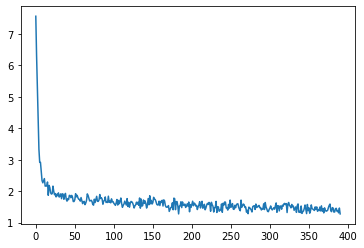

Epoch 0 done.

Average test loss: 1.4118  Accuracy: 4907/10000 (49.07%)


Average train loss: 1.4127  Accuracy:24736/50000 (49.47%)

[    0/50000 (  0%)]  Loss: 1.3557
[12800/50000 ( 26%)]  Loss: 1.3000
[25600/50000 ( 51%)]  Loss: 1.2758
[38400/50000 ( 77%)]  Loss: 1.4492


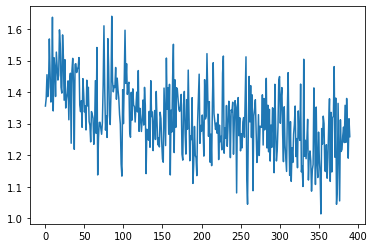

Epoch 1 done.

Average test loss: 1.3614  Accuracy: 5101/10000 (51.01%)


Average train loss: 1.3466  Accuracy:25838/50000 (51.68%)

[    0/50000 (  0%)]  Loss: 1.2203
[12800/50000 ( 26%)]  Loss: 1.1170
[25600/50000 ( 51%)]  Loss: 1.3938
[38400/50000 ( 77%)]  Loss: 1.3090


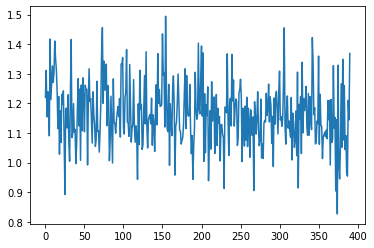

Epoch 2 done.

Average test loss: 1.1059  Accuracy: 6076/10000 (60.76%)


Average train loss: 1.0834  Accuracy:30753/50000 (61.51%)

[    0/50000 (  0%)]  Loss: 1.0674
[12800/50000 ( 26%)]  Loss: 1.0845
[25600/50000 ( 51%)]  Loss: 0.8581
[38400/50000 ( 77%)]  Loss: 0.9677


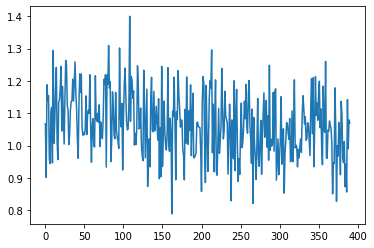

Epoch 3 done.

Average test loss: 1.0784  Accuracy: 6222/10000 (62.22%)


Average train loss: 1.0353  Accuracy:31796/50000 (63.59%)

[    0/50000 (  0%)]  Loss: 0.9508
[12800/50000 ( 26%)]  Loss: 0.9955
[25600/50000 ( 51%)]  Loss: 0.9411
[38400/50000 ( 77%)]  Loss: 1.0001


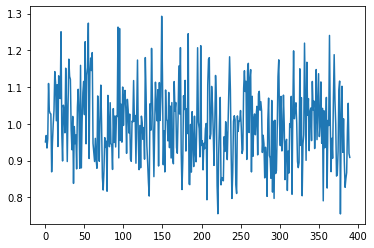

Epoch 4 done.

Average test loss: 0.9920  Accuracy: 6541/10000 (65.41%)


Average train loss: 0.9538  Accuracy:33243/50000 (66.49%)

[    0/50000 (  0%)]  Loss: 1.0620
[12800/50000 ( 26%)]  Loss: 1.0360
[25600/50000 ( 51%)]  Loss: 1.0454
[38400/50000 ( 77%)]  Loss: 0.9374


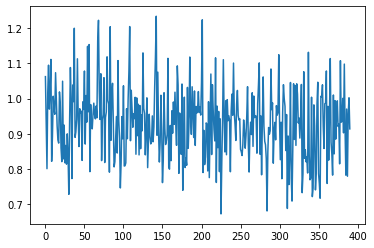

Epoch 5 done.

Average test loss: 0.9509  Accuracy: 6676/10000 (66.76%)


Average train loss: 0.9161  Accuracy:33813/50000 (67.63%)

[    0/50000 (  0%)]  Loss: 1.0047
[12800/50000 ( 26%)]  Loss: 0.7623
[25600/50000 ( 51%)]  Loss: 0.8206
[38400/50000 ( 77%)]  Loss: 0.7326


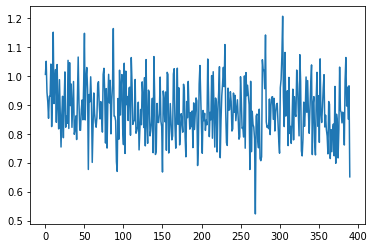

Epoch 6 done.

Average test loss: 0.9440  Accuracy: 6668/10000 (66.68%)


Average train loss: 0.8911  Accuracy:34346/50000 (68.69%)

[    0/50000 (  0%)]  Loss: 0.8299
[12800/50000 ( 26%)]  Loss: 0.7814
[25600/50000 ( 51%)]  Loss: 0.6839
[38400/50000 ( 77%)]  Loss: 0.7586


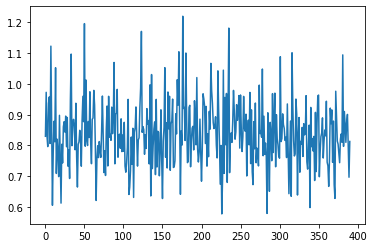

Epoch 7 done.

Average test loss: 0.9071  Accuracy: 6910/10000 (69.10%)


Average train loss: 0.8421  Accuracy:35428/50000 (70.86%)

[    0/50000 (  0%)]  Loss: 0.7207
[12800/50000 ( 26%)]  Loss: 0.9011
[25600/50000 ( 51%)]  Loss: 0.5427
[38400/50000 ( 77%)]  Loss: 0.7443


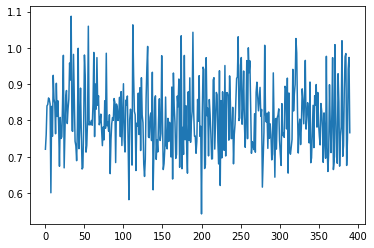

Epoch 8 done.

Average test loss: 0.8487  Accuracy: 7057/10000 (70.57%)


Average train loss: 0.7874  Accuracy:36195/50000 (72.39%)

[    0/50000 (  0%)]  Loss: 0.6025
[12800/50000 ( 26%)]  Loss: 0.6445
[25600/50000 ( 51%)]  Loss: 0.9918
[38400/50000 ( 77%)]  Loss: 0.8037


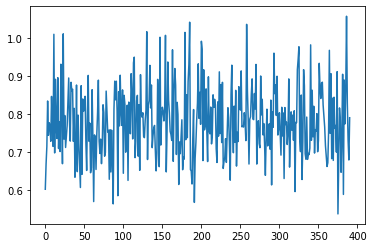

Epoch 9 done.

Average test loss: 0.8381  Accuracy: 7101/10000 (71.01%)


Average train loss: 0.7608  Accuracy:36634/50000 (73.27%)

[    0/50000 (  0%)]  Loss: 0.7360
[12800/50000 ( 26%)]  Loss: 0.7268
[25600/50000 ( 51%)]  Loss: 0.5873
[38400/50000 ( 77%)]  Loss: 0.7593


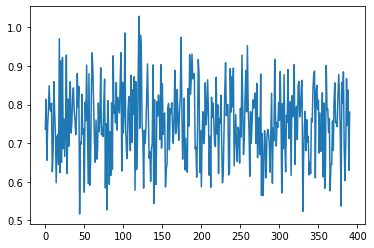

Epoch 10 done.

Average test loss: 0.8121  Accuracy: 7209/10000 (72.09%)


Average train loss: 0.7347  Accuracy:37183/50000 (74.37%)

[    0/50000 (  0%)]  Loss: 0.6789
[12800/50000 ( 26%)]  Loss: 0.9327
[25600/50000 ( 51%)]  Loss: 0.7539
[38400/50000 ( 77%)]  Loss: 0.7585


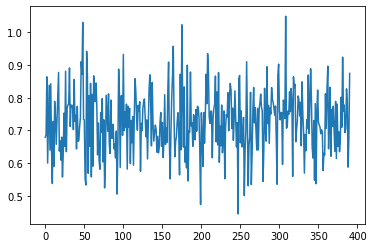

Epoch 11 done.

Average test loss: 0.8251  Accuracy: 7215/10000 (72.15%)


Average train loss: 0.7365  Accuracy:37287/50000 (74.57%)

[    0/50000 (  0%)]  Loss: 0.7014
[12800/50000 ( 26%)]  Loss: 0.7738
[25600/50000 ( 51%)]  Loss: 0.6860
[38400/50000 ( 77%)]  Loss: 0.6373


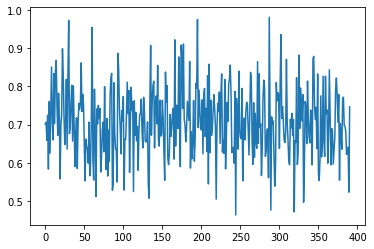

Epoch 12 done.

Average test loss: 0.7545  Accuracy: 7387/10000 (73.87%)


Average train loss: 0.6750  Accuracy:38221/50000 (76.44%)

[    0/50000 (  0%)]  Loss: 0.7400
[12800/50000 ( 26%)]  Loss: 0.7563
[25600/50000 ( 51%)]  Loss: 0.5475
[38400/50000 ( 77%)]  Loss: 0.5163


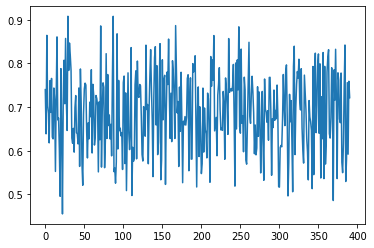

Epoch 13 done.

Average test loss: 0.7599  Accuracy: 7376/10000 (73.76%)


Average train loss: 0.6691  Accuracy:38305/50000 (76.61%)

[    0/50000 (  0%)]  Loss: 0.7493
[12800/50000 ( 26%)]  Loss: 0.8101
[25600/50000 ( 51%)]  Loss: 0.8918
[38400/50000 ( 77%)]  Loss: 0.5266


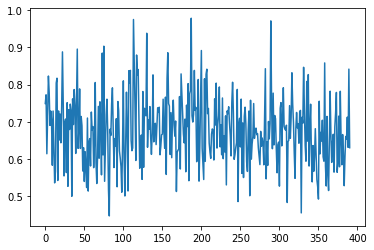

Epoch 14 done.

Average test loss: 0.7352  Accuracy: 7453/10000 (74.53%)


Average train loss: 0.6405  Accuracy:38883/50000 (77.77%)

[    0/50000 (  0%)]  Loss: 0.5956


KeyboardInterrupt: ignored

In [ ]:
epochs = 30
lr = 0.001
lr_decay = 1
decay_every = 30
weight_decay = 4e-5
optim = torch.optim.Adam
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)


N = 128

train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=N, shuffle=False)

valid_acc, train_acc, all_hist = train_attempt(
    resnet, 
    optimizer, 
    train_loader, 
    valid_loader, 
    epochs,
    lr,
    lr_decay,
    decay_every,
    weight_decay,
    optim
)

print(valid_acc, train_acc)